In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/NLP/Project3/
%ls

Mounted at /content/drive
/content/drive/MyDrive/NLP/Project3
1/  3/        glove.6B.50d.txt  Project_show.ipynb
2/  dataset/  Project_3.ipynb   sample_3.ipynb


In [ ]:
import numpy as np
import pandas as pd 
import tensorflow as tf 
from keras.layers import Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Embedding,LSTM,Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import losses
from tensorflow.keras import backend
from tensorflow.keras import callbacks
import keras
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Input,Dropout
from keras.layers import concatenate,AveragePooling1D,GlobalMaxPooling1D

In [ ]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

In [ ]:
train = load_doc('dataset/train_low.txt')
test = load_doc('dataset/test.txt')

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer


def remove_stop_words(value):
    try:
        nltk.data.find('tokenizers/punkt')
    except LookupError:
        nltk.download('punkt')

    stop_words = set(stopwords.words('english'))

    word_tokens = word_tokenize(value)

    filtered_sentence = [word for word in word_tokens if word not in stopwords.words('english')]

    filtered_sentence = []

    for w in word_tokens:
        if w not in stop_words:
            filtered_sentence.append(w)

    return TreebankWordDetokenizer().detokenize(filtered_sentence).replace('\\', '')

In [ ]:
import nltk
nltk.download('stopwords')
train=remove_stop_words(train)
test=remove_stop_words(test)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
tokenizer_train = Tokenizer()
tokenizer_train.fit_on_texts([train])
encoded_train = tokenizer_train.texts_to_sequences([train])[0]

tokenizer_test = Tokenizer()
tokenizer_test.fit_on_texts([test])
encoded_test = tokenizer_test.texts_to_sequences([test])[0]

In [ ]:
vocab_size_train = len(tokenizer_train.word_index) + 1
print('Vocabulary Size: %d' % vocab_size_train)

vocab_size_test = len(tokenizer_test.word_index) + 1
print('Vocabulary Size: %d' % vocab_size_test)

Vocabulary Size: 15301
Vocabulary Size: 6290


In [ ]:
#five gram

sequences_train = list()
for i in range(4, len(encoded_train)):
    sequence_train = encoded_train[i-3:i+2]
    sequences_train.append(sequence_train)
print('Total Sequences train: %d' % len(sequences_train))    

sequences_test = list()
for i in range(4, len(encoded_test)):
    sequence_test = encoded_test[i-3:i+2]
    sequences_test.append(sequence_test)
print('Total Sequences test: %d' % len(sequences_test))    

Total Sequences train: 57048
Total Sequences test: 12344


In [ ]:
max_length_train = max([len(seq) for seq in sequences_train])
sequences_train = pad_sequences(sequences_train, maxlen=max_length_train, padding='pre')
print('Max Sequences train Length: %d' % max_length_train)

max_length_test = max([len(seq) for seq in sequences_test])
sequences_test = pad_sequences(sequences_test, maxlen=max_length_test, padding='pre')
print('Max Sequences test Length: %d' % max_length_test)

Max Sequences train Length: 5
Max Sequences test Length: 5


In [ ]:
sequences_train = np.array(sequences_train)
X_train, y_train = sequences_train[:,:-1],sequences_train[:,-1]

sequences_test = np.array(sequences_test)
X_test, y_test = sequences_test[:,:-1],sequences_test[:,-1]

In [ ]:
y_train = to_categorical(y_train, num_classes=vocab_size_train)

In [ ]:
y_test = to_categorical(y_test, num_classes=vocab_size_train)

In [ ]:
def perplexity(y_true, y_pred):
    cross_entropy = losses.categorical_crossentropy(y_true, y_pred)
    perplexity = backend.pow(2.0, cross_entropy)
    return perplexity

In [ ]:
# Prepare Glove File
def readGloveFile(gloveFile):
    with open(gloveFile, 'r') as f:
        wordToGlove = {}  # map from a token (word) to a Glove embedding vector
        wordToIndex = {}  # map from a token to an index
        indexToWord = {}  # map from an index to a token 

        for line in f:
            record = line.strip().split()
            token = record[0] # take the token (word) from the text line
            wordToGlove[token] = np.array(record[1:], dtype=np.float64) # associate the Glove embedding vector to a that token (word)

        tokens = sorted(wordToGlove.keys())
        for idx, tok in enumerate(tokens):
            kerasIdx = idx + 1  # 0 is reserved for masking in Keras (see above)
            wordToIndex[tok] = kerasIdx # associate an index to a token (word)
            indexToWord[kerasIdx] = tok # associate a word to a token (word). Note: inverse of dictionary above

    return wordToIndex, indexToWord, wordToGlove

# Create Pretrained Keras Embedding Layer
def createPretrainedEmbeddingLayer(wordToGlove, wordToIndex, isTrainable):
    vocabLen = len(wordToIndex) + 1  # adding 1 to account for masking
    embDim = next(iter(wordToGlove.values())).shape[0]  # works with any glove dimensions (e.g. 50)

    embeddingMatrix = np.zeros((vocabLen, embDim))  # initialize with zeros
    for word, index in wordToIndex.items():
        embeddingMatrix[index, :] = wordToGlove[word] # create embedding: word index to Glove word embedding

    embeddingLayer = Embedding(vocabLen, embDim, weights=[embeddingMatrix], input_length=max_length_train-1, trainable=isTrainable)
    return embeddingLayer

# usage
wordToIndex, indexToWord, wordToGlove = readGloveFile("glove.6B.50d.txt")
pretrainedEmbeddingLayer = createPretrainedEmbeddingLayer(wordToGlove, wordToIndex, False)


In [ ]:
model = Sequential()
model.add(pretrainedEmbeddingLayer)
model.add(Flatten())
model.add(Dense(35, activation='sigmoid'))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(vocab_size_train, activation='softmax'))

gd=tf.keras.optimizers.SGD(
    learning_rate=0.02,
    name='SGD'
)

model.compile(loss='categorical_crossentropy', optimizer=gd, metrics=[perplexity])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 4, 50)             20000050  
_________________________________________________________________
flatten (Flatten)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 35)                7035      
_________________________________________________________________
dropout (Dropout)            (None, 35)                0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 35)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 15301)             550836    
Total params: 20,557,921
Trainable params: 557,871
Non-trainable params: 20,000,050
______________________________________

In [ ]:
metrics = model.fit(X_train, y_train, epochs=100,batch_size=25)

Epoch 1/100
2282/2282 [==============================] - 22s 9ms/step - loss: 9.4856 - perplexity: 758.3750
Epoch 2/100
2282/2282 [==============================] - 23s 10ms/step - loss: 9.1402 - perplexity: 672.2408
Epoch 3/100
2282/2282 [==============================] - 22s 10ms/step - loss: 8.8951 - perplexity: 629.2902
Epoch 4/100
2282/2282 [==============================] - 26s 11ms/step - loss: 8.7446 - perplexity: 614.8703
Epoch 5/100
2282/2282 [==============================] - 20s 9ms/step - loss: 8.6865 - perplexity: 614.9957
Epoch 6/100
2282/2282 [==============================] - 21s 9ms/step - loss: 8.6610 - perplexity: 617.3013
Epoch 7/100
2282/2282 [==============================] - 20s 9ms/step - loss: 8.6252 - perplexity: 619.0501
Epoch 8/100
2282/2282 [==============================] - 23s 10ms/step - loss: 8.5986 - perplexity: 617.8567
Epoch 9/100
2282/2282 [==============================] - 23s 10ms/step - loss: 8.5965 - perplexity: 622.6049
Epoch 10/100
2282/2282 

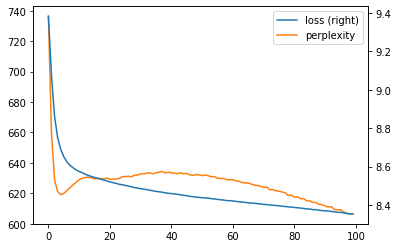

In [ ]:
result = pd.DataFrame.from_dict(metrics.history)
result.plot.line(secondary_y=["loss", "val_loss"])

In [ ]:
print(model.evaluate(X_test,y_test))

386/386 [==============================] - 2s 6ms/step - loss: 8.6445 - perplexity: 559.4490
[8.644495010375977, 559.448974609375]
